In [1]:
# 표준 오토인코더
# 확장을 해서 변이형 오토인코더

https://gilbertlim.github.io/deep%20learning/dl_variational_autoencoder/

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets
(x_train,y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
import numpy as np

In [5]:
# 첫번째 차원은 가장 바깥쪽 차원을 0개 추가 그래서 변하지 않음
# 두번째 차원은 좌,우 각각 2개의 값으로 추가, 좌우 각각2열이 0으로 패딩이 추가
# 세번째 차원은 위,아래 각각 2개의 값으로 추가, 좌우 각각2열이 0으로 패딩이 추가
temp = np.pad(x_train,((0,0),(2,2),(2,2)),constant_values=0.0)
print(temp.shape)
np.expand_dims(temp,-1).shape

(60000, 32, 32)


(60000, 32, 32, 1)

In [6]:
# 전처리 : float32, /255.0
# 각 이미지에 패딩을 적용해서 32 x 32 : 신경망 통과시 텐서의 크기를 쉽게 조작할수 있도록
def preprocess(imgs):
  imgs = imgs.astype('float32') / 255.0
  imgs = np.pad(imgs,((0,0),(2,2),(2,2)),constant_values=0.0)
  imgs = np.expand_dims(imgs,-1)
  return imgs
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [7]:
# 인코더 : 고차원 입력데이터를 저차원 임베딩 벡터로 압축
# 디코더 : 임베딩 벡터를 원본 도메인으로 압축 해제(이미지로 되돌린다)
# 인코더를 수행하면...특징들을 모은 임베딩(잠재공간).. 임베딩을 샘플링해서 디코더에 넣으면 새로운 이미지생성

In [8]:
from tensorflow.keras import layers,models
import tensorflow.keras.backend as k

In [9]:
k.int_shape(x_train)

(60000, 32, 32, 1)

In [10]:
#인코더
encorder_input = layers.Input(shape=(32, 32, 1))
x = layers.Conv2D(32,(3,3),strides=2,activation='relu',padding='same')(encorder_input)
x = layers.Conv2D(64,(3,3),strides=2,activation='relu',padding='same')(x)
x = layers.Conv2D(128,(3,3),strides=2,activation='relu',padding='same')(x)
shape_before_flatten = k.int_shape(x)[1:]  # 디코더에서 사용
x = layers.Flatten()(x)
encorder_output = layers.Dense(2)(x)
encorder = models.Model(encorder_input,encorder_output)

In [11]:
encorder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [12]:
# np.prod(shape_before_flatten), shape_before_flatten

In [13]:
# 디코더
decorder_input = layers.Input(shape=(2,))
x = layers.Dense(np.prod(shape_before_flatten))(decorder_input) # 2048
x = layers.Reshape(shape_before_flatten)(x)
x = layers.Conv2DTranspose(128,(3,3),strides=2,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(64,(3,3),strides=2,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(32,(3,3),strides=2,activation='relu',padding='same')(x)
decoder_output = layers.Conv2D(1,(3,3),strides=1,activation='sigmoid',padding='same')(x) # 이미지 그려야..
decorder = models.Model(decorder_input,decoder_output)

In [14]:
decorder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [15]:
#오토인코더 : 인코더+디코더
autoencorder = models.Model(encorder_input, decorder(encorder_output))  # 이미지를 입력으로 받아서 인코더와 디코더를 통과

In [16]:
autoencorder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

In [17]:
autoencorder.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
x_train.shape, y_train.shape

((60000, 32, 32, 1), (60000,))

In [19]:
autoencorder.fit(x_train,x_train,epochs=50,batch_size=100,
                 shuffle=True,validation_data=(x_test,x_test))

Epoch 1/50
600/600 [==============================] - 22s 12ms/step - loss: 0.2971 - val_loss: 0.2655
Epoch 2/50
600/600 [==============================] - 7s 12ms/step - loss: 0.2593 - val_loss: 0.2577
Epoch 3/50
600/600 [==============================] - 7s 11ms/step - loss: 0.2553 - val_loss: 0.2555
Epoch 4/50
600/600 [==============================] - 7s 12ms/step - loss: 0.2532 - val_loss: 0.2548
Epoch 5/50
600/600 [==============================] - 7s 11ms/step - loss: 0.2520 - val_loss: 0.2538
Epoch 6/50
600/600 [==============================] - 7s 11ms/step - loss: 0.2511 - val_loss: 0.2522
Epoch 7/50
600/600 [==============================] - 7s 11ms/step - loss: 0.2500 - val_loss: 0.2524
Epoch 8/50
600/600 [==============================] - 7s 11ms/step - loss: 0.2493 - val_loss: 0.2513
Epoch 9/50
600/600 [==============================] - 7s 12ms/step - loss: 0.2488 - val_loss: 0.2501
Epoch 10/50
600/600 [==============================] - 7s 11ms/step - loss: 0.2482 - val_l

In [20]:
import utils

In [21]:
predictions = autoencorder.predict( x_test[:5000])

157/157 [==============================] - 1s 4ms/step


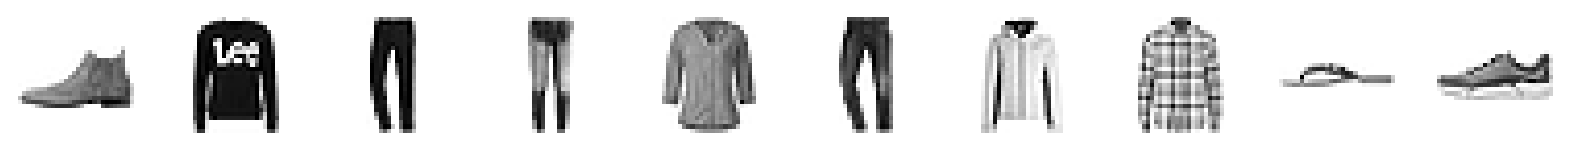

In [22]:
utils.display(x_test[:5000])

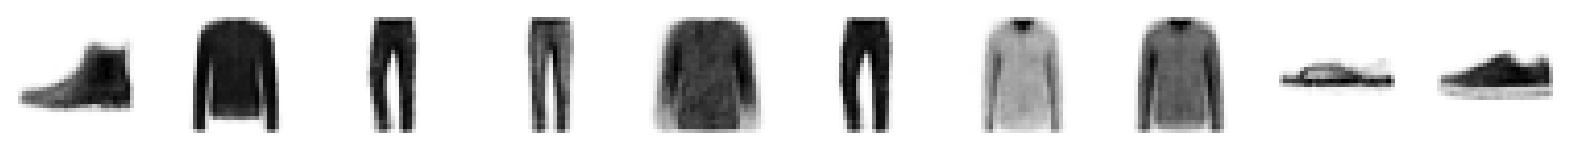

In [23]:
utils.display(predictions)

In [24]:
# 인코더.. 이미지 임베딩
embedding = encorder.predict(x_test[:5000])

157/157 [==============================] - 0s 2ms/step


In [25]:
mins,maxs = np.min(embedding,axis=0), np.max(embedding,axis=0)
sample = np.random.uniform(mins,maxs,size=(18,2))
sample.shape
new_images =  decorder.predict(sample)

1/1 [==============================] - 0s 218ms/step


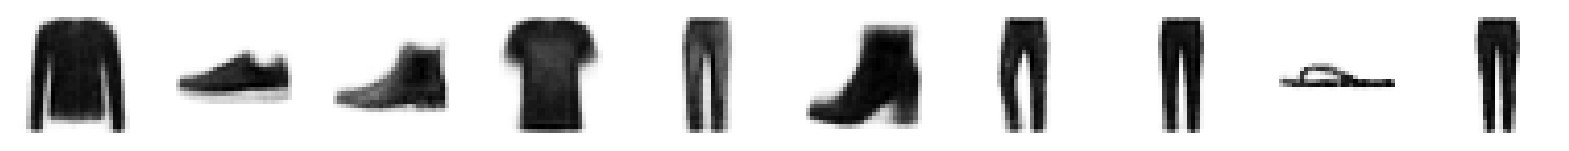

In [26]:
utils.display(new_images)